<a href="https://colab.research.google.com/github/shubham261r/Metro-analysis-project/blob/main/Metro_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import folium
metro_data = pd.read_csv("Delhi Metro Network new.csv")
print(metro_data.head())


   Station ID         Station Name  Distance from Start (km)          Line  \
0           1             Jhil Mil                      10.3      Red line   
1           2  Welcome [Conn: Red]                      46.8     Pink line   
2           3          DLF Phase 3                      10.0   Rapid Metro   
3           4           Okhla NSIC                      26.3  Magenta line   
4           5           Dwarka Mor                      10.2     Blue line   

  Opening Date Station Layout   Latitude  Longitude  
0     6-Apr-08       Elevated  28.675790  77.312390  
1    31-Oct-18       Elevated  28.671800  77.277560  
2    14-Nov-13       Elevated  28.493600  77.093500  
3    25-Dec-17       Elevated  28.554483  77.264849  
4    30-Dec-05       Elevated  28.619320  77.033260  


In [3]:
line_colors = {
    'Red line': 'red',
    'Blue line': 'blue',
    'Yellow line': 'beige',
    'Green line': 'green',
    'Voilet line': 'purple',
    'Pink line': 'pink',
    'Magenta line': 'darkred',
    'Orange line': 'orange',
    'Rapid Metro': 'cadetblue',
    'Aqua line': 'black',
    'Green line branch': 'lightgreen',
    'Blue line branch': 'lightblue',
    'Gray line': 'lightgray'
}
delhi_map_with_line_tooltip = folium.Map(location=[28.7041, 77.1025], zoom_start=11)

for _, row in metro_data.iterrows():
    line = row['Line']
    color = line_colors.get(line, 'black')
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Station Name'],
        tooltip=f"{row['Station Name']}, {line}",
        icon=folium.Icon(color=color)
    ).add_to(delhi_map_with_line_tooltip)

# Save and open
delhi_map_with_line_tooltip.save("delhi_metro_map.html")

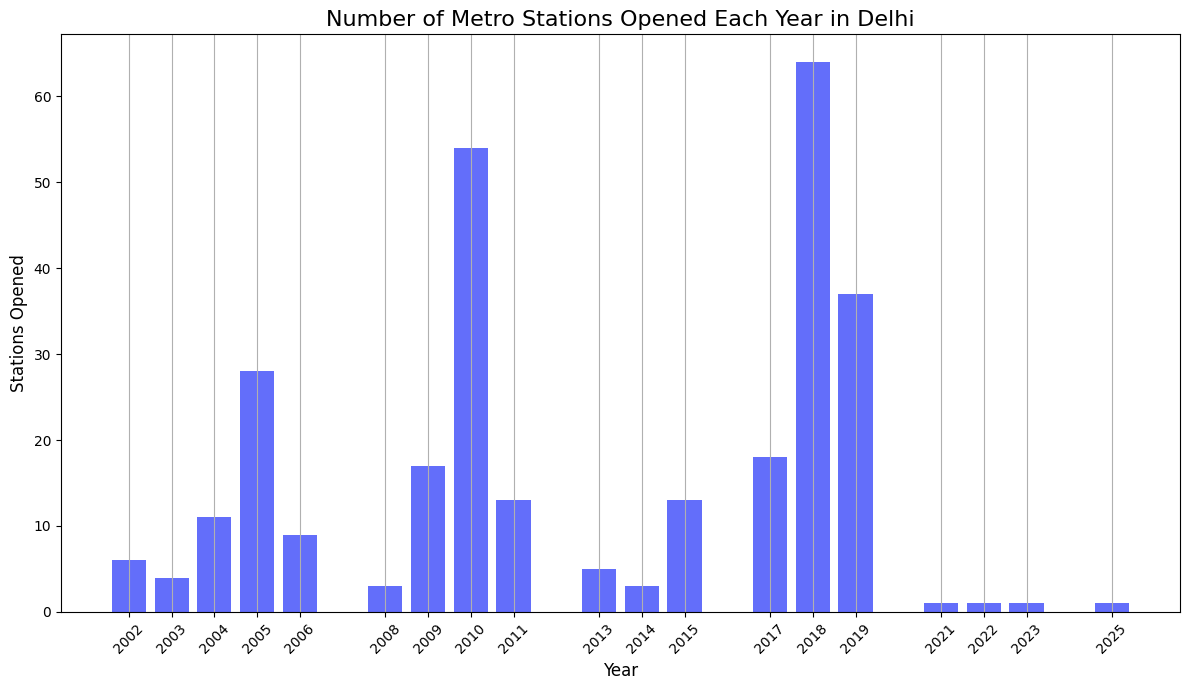

In [5]:
# Data Preparation
metro_data['Opening Date'] = pd.to_datetime(metro_data['Opening Date'], dayfirst=True, errors='coerce')
metro_data_cleaned = metro_data.dropna(subset=['Opening Date'])
metro_data_cleaned['Opening Year'] = metro_data_cleaned['Opening Date'].dt.year

stations_per_year = metro_data_cleaned['Opening Year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 7))
plt.bar(stations_per_year.index, stations_per_year.values, color='#636efa')

plt.title('Number of Metro Stations Opened Each Year in Delhi', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Stations Opened', fontsize=12)
plt.xticks(stations_per_year.index, rotation=45)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

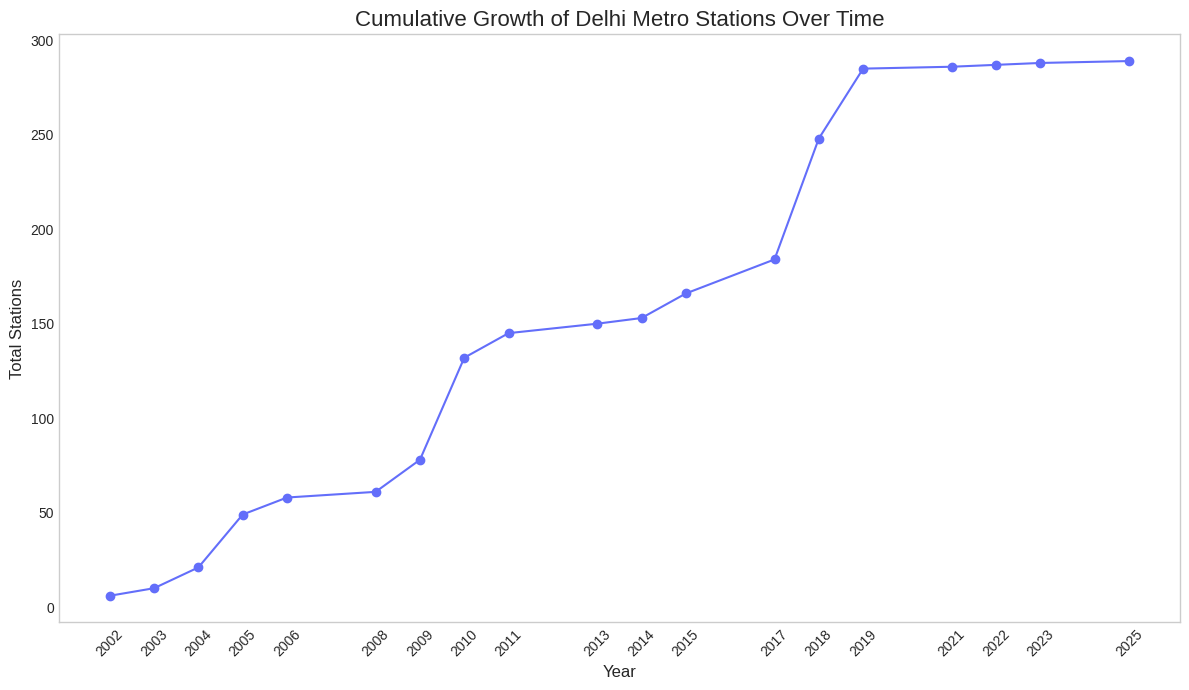

In [ ]:
# Data Preparation
cumulative_stations = stations_per_year.cumsum()

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(cumulative_stations.index, cumulative_stations.values, marker='o', linestyle='-', color='#636efa')

plt.title('Cumulative Growth of Delhi Metro Stations Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Stations', fontsize=12)
plt.xticks(cumulative_stations.index, rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

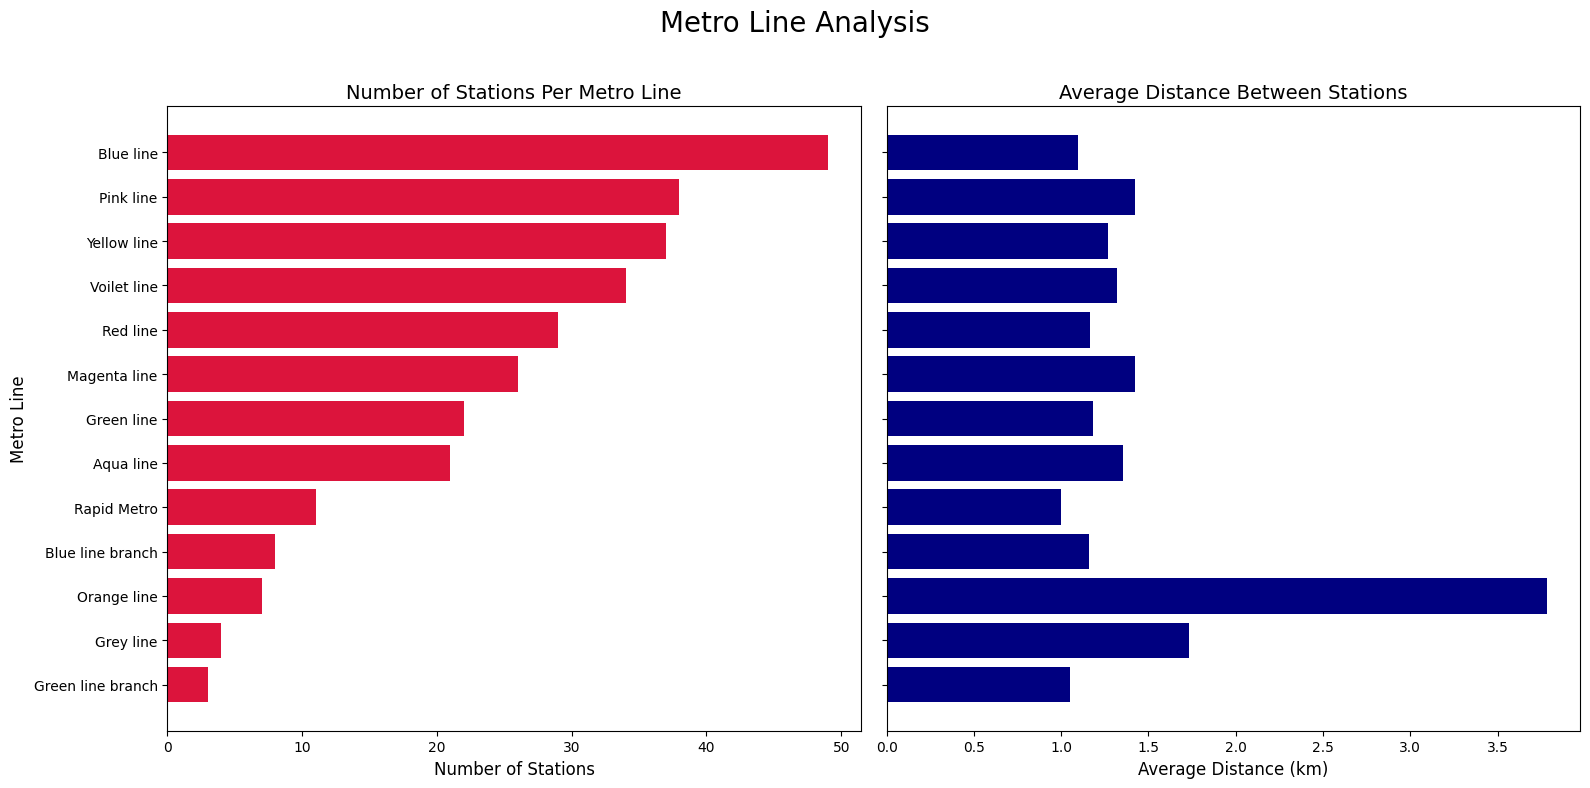

In [6]:
# Data Preparation
stations_per_line = metro_data['Line'].value_counts()
total_distance_per_line = metro_data.groupby('Line')['Distance from Start (km)'].max()
# The formula (stations - 1) gives the number of segments between stations
avg_distance_per_line = total_distance_per_line / (stations_per_line - 1)

line_analysis = pd.DataFrame({
    'Number of Stations': stations_per_line,
    'Average Distance Between Stations (km)': avg_distance_per_line
})
line_analysis = line_analysis.sort_values(by='Number of Stations', ascending=True)


# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Metro Line Analysis', fontsize=20)

# Subplot 1: Number of Stations
axes[0].barh(line_analysis.index, line_analysis['Number of Stations'], color='crimson')
axes[0].set_title('Number of Stations Per Metro Line', fontsize=14)
axes[0].set_xlabel('Number of Stations', fontsize=12)
axes[0].set_ylabel('Metro Line', fontsize=12)

# Subplot 2: Average Distance Between Stations
axes[1].barh(line_analysis.index, line_analysis['Average Distance Between Stations (km)'], color='navy')
axes[1].set_title('Average Distance Between Stations', fontsize=14)
axes[1].set_xlabel('Average Distance (km)', fontsize=12)
axes[1].yaxis.set_ticklabels([]) # Hide y-axis labels to avoid repetition

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.grid(False)
plt.show()

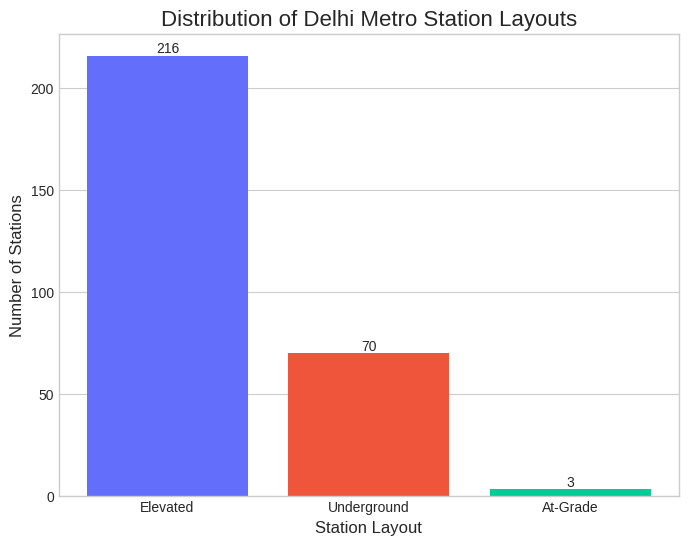

In [ ]:
# Data Preparation
layout_counts = metro_data['Station Layout'].value_counts()
colors = ['#636efa', '#EF553B', '#00cc96']

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(layout_counts.index, layout_counts.values, color=colors)

plt.title('Distribution of Delhi Metro Station Layouts', fontsize=16)
plt.xlabel('Station Layout', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.grid(axis='x')

# Add data labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.show()

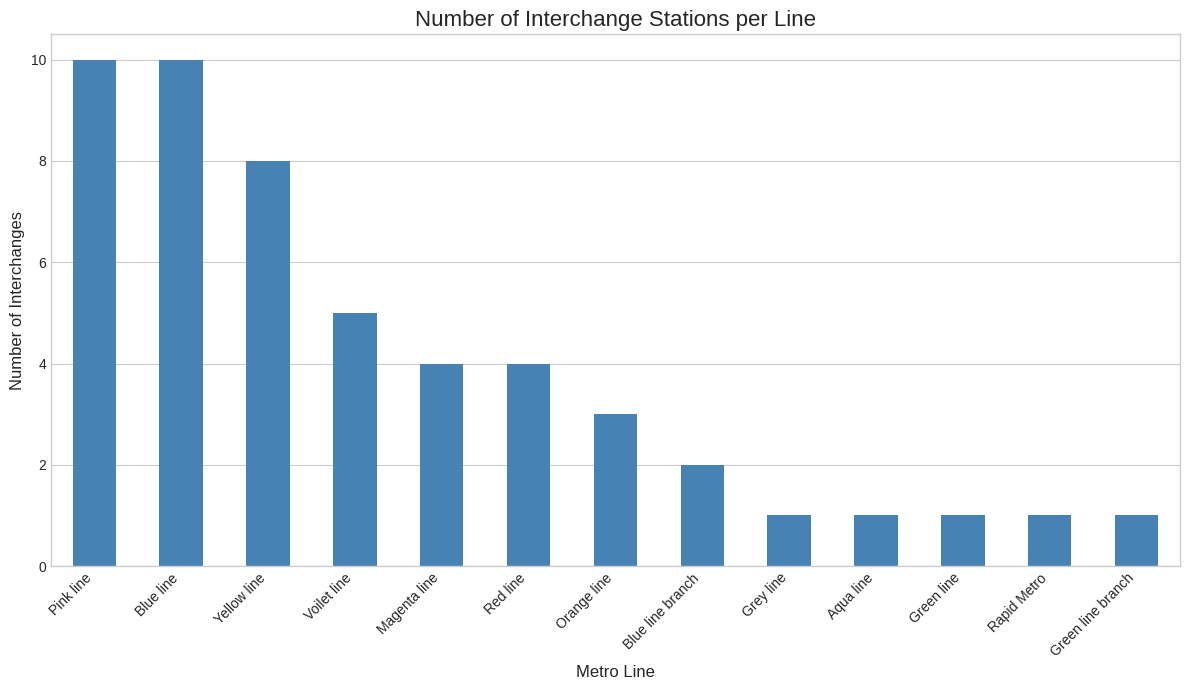

In [ ]:
# Data Preparation
metro_data["Interchange"] = metro_data["Station Name"].apply(lambda x: "Yes" if "Conn:" in x else "No")
interchanges = metro_data[metro_data["Interchange"] == "Yes"]
interchange_counts = interchanges['Line'].value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 7))
interchange_counts.plot(kind='bar', color='steelblue')

plt.title('Number of Interchange Stations per Line', fontsize=16)
plt.xlabel('Metro Line', fontsize=12)
plt.ylabel('Number of Interchanges', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

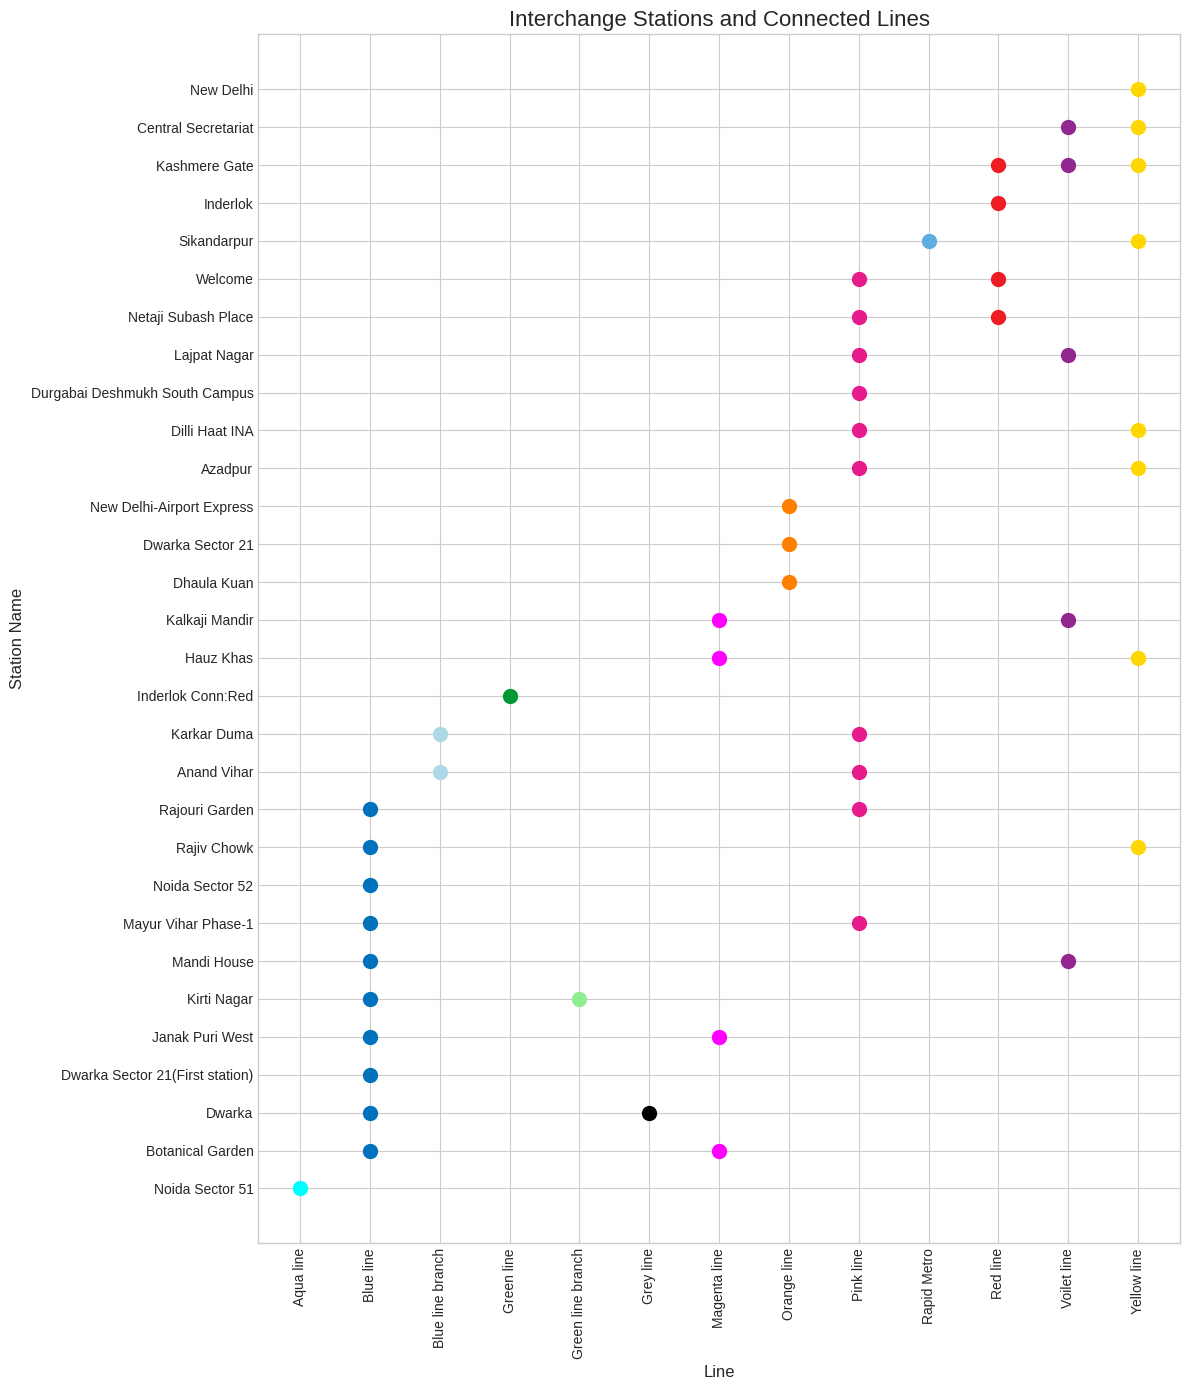

In [ ]:
# Data Preparation
metro_data["Clean Station Name"] = metro_data["Station Name"].str.replace(r"\s*\[.*\]", "", regex=True).str.strip()
interchanges_detailed = metro_data[metro_data["Interchange"] == "Yes"].copy()

# Sort for better visualization
interchanges_detailed = interchanges_detailed.sort_values(by=["Line", "Clean Station Name"])

# Plotting
plt.figure(figsize=(12, 14))

# Use a categorical scatter plot approach
for line in interchanges_detailed['Line'].unique():
    line_df = interchanges_detailed[interchanges_detailed['Line'] == line]
    plt.plot(line_df['Line'],line_df['Clean Station Name'],
             marker='o',
             linestyle='',
             label=line,
             color=line_colors_hex.get(line, 'black'),
             markersize=10)

plt.title('Interchange Stations and Connected Lines', fontsize=16)
plt.xlabel('Line', fontsize=12)
plt.ylabel('Station Name', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()